In [44]:
import numpy as np
import scipy
from scipy import signal
import math
from scipy.io import readsav
import matplotlib.pyplot as plt
import cv2
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Functions for loading data

In [45]:
def _load_data(filename):
    dat = readsav(filename)
    emission = dat['emission_structure']
    return emission[0]

def _find_index(arr,val):
    return np.argmin(abs(arr-val))

### Functions for enhancing images

In [46]:
def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

# gaussian filtering
def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

# mean filtering
def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

# morphological filtering
def morph(src):
    src = (rescale(src)*255).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return rescale(mask)

### Load data

In [47]:
# [inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = _load_data('/scratch/gpfs/aj17/plasmatv_data/tv_images/emission_structure_pu_cam240perp_185821.sav')

[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = _load_data('emission_structure_pu_cam240perp_185821.sav')

### Try to find the X point and visualize data

In [48]:
print(times.size)

211


[]

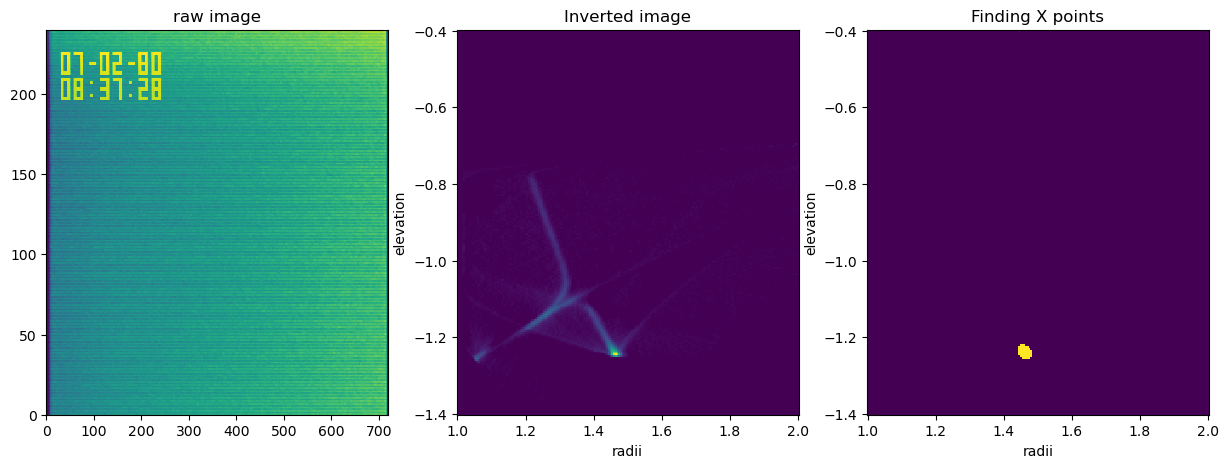

In [63]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
fid =1
tid = _find_index(vid_times,times[fid]) #find frame id for camera image with t=times[fid]

find_x = inverted[fid]
find_x = find_x/7.5 # max value of inverted in whole dataset

find_x = np.power(find_x,2)

gaussblr_win = (11,11) # Gaussian blur filter size
find_x =  gaussblr(find_x,gaussblr_win)
find_x = meansub(find_x)    
# Sxx_enhanced = morph(Sxx_enhanced)
# Sxx_enhanced = meansub(Sxx_enhanced)
find_x  = np.where(find_x<0.3,0,1) # Threshold of 0.3 to detect spot


ax[0].pcolormesh(vid[fid][::-1,:])
ax[0].set(title='raw image')
ax[1].pcolormesh(radii[fid],elevation[fid],inverted[fid],shading='auto')
ax[1].set(title='Inverted image',xlabel='radii',ylabel='elevation')
ax[2].pcolormesh(radii[fid],elevation[fid],find_x,shading='auto')
ax[2].set(title='Finding X points',xlabel='radii',ylabel='elevation')
plt.plot()

### Edge Detection

[[ 1.475 -1.245]
 [ 1.055 -1.255]
 [ 1.325 -1.09 ]]


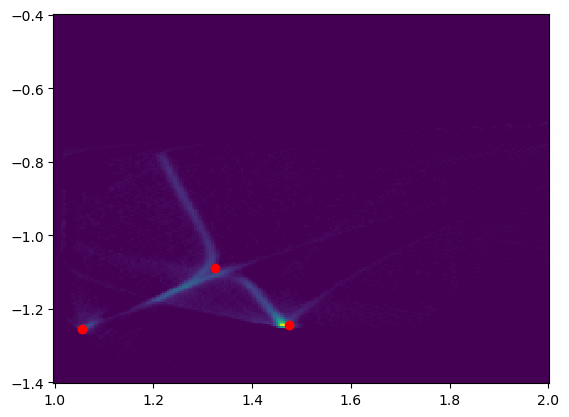

In [64]:
img = inverted[fid].copy()
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')
useHarrisDetector = False # False uses Shi-Tomasi Corner Detector
corners = cv2.goodFeaturesToTrack(gray,3,0.01,10, useHarrisDetector=useHarrisDetector)
corners = np.intp(corners)
x = radii[fid][corners[:,0,0]]
y = elevation[fid][corners[:,0,1]]
print(np.column_stack((x,y)))
plt.pcolormesh(radii[fid],elevation[fid],img,shading='auto')
plt.scatter(x,y,color='red')
plt.show()

### Detecting lines in raw image (lines correspond to XPR and Emission Front)


In [7]:
img = np.sqrt(vid[tid]).copy()
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')

# reduce the noise using Gaussian filters
kernel_size = 11 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Apply Canny edge detctor
low_threshold = 10
high_threshold = 20
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Apply Hough transform
rho = 1  # This is the distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.zeros((img.shape[0],img.shape[1],3))  # creating a blank to draw lines on


lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) # The output "lines" is an array containing endpoints of detected line segments

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

        
line_len=[]
for line in lines:
    for x1,y1,x2,y2 in line:
        line_len.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
        
# add the line_image as an extra layer on top of the original image
lines_edges = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 1, line_image, 0.5, 0,dtype =0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Text(0.5, 1.0, 'Final result')]

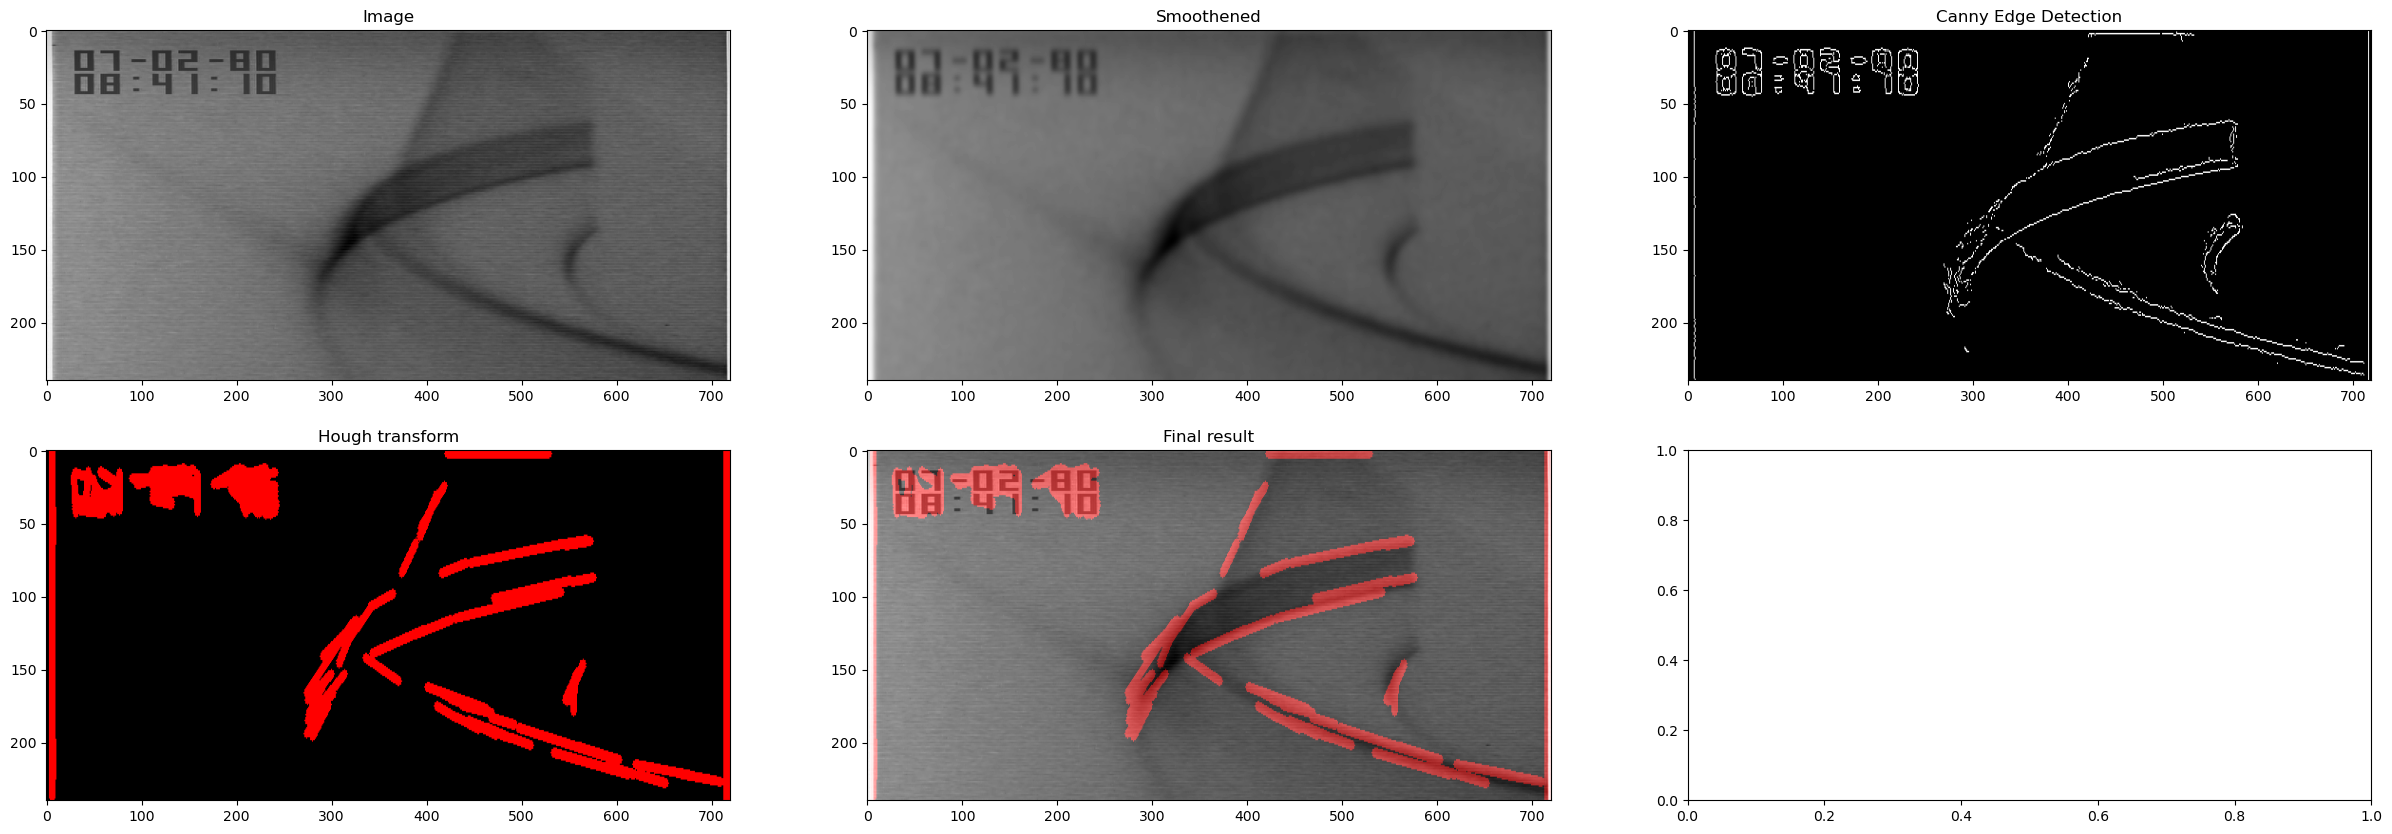

In [8]:
# plots
fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(30,10))


ax[0,0].imshow(gray,cmap='gray',aspect='auto')
ax[0,0].set(title='Image')

ax[0,1].imshow(blur_gray,cmap='gray',aspect='auto')
ax[0,1].set(title='Smoothened')

ax[0,2].imshow(edges,cmap='gray',aspect='auto')
ax[0,2].set (title='Canny Edge Detection')

ax[1, 0].imshow(line_image,cmap='gray',aspect='auto')
ax[1, 0].set(title='Hough transform')

ax[1, 1].imshow(lines_edges,aspect='auto')
ax[1, 1].set(title='Final result')


## Other Filtering Methods

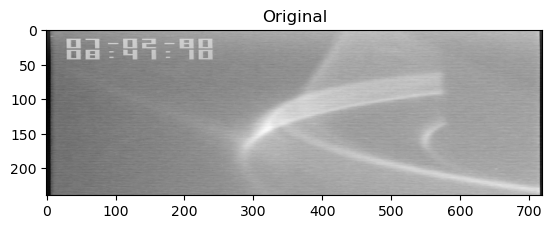

In [9]:
img = np.sqrt(vid[tid]).copy() # [25:250,250:700]
ratio = np.amax(img) / 255
img8 = (img/ratio).astype('uint8')
kernel_size = 5
blur_gray = cv2.GaussianBlur(img8,(kernel_size, kernel_size),0)

# img = cv2.imread('zhang4ab-2828863-large.jpg')
# img8 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[100:200,100:200]

plt.imshow(img8, cmap='gray')
plt.title('Original')
plt.show()

### Fourier Shifting

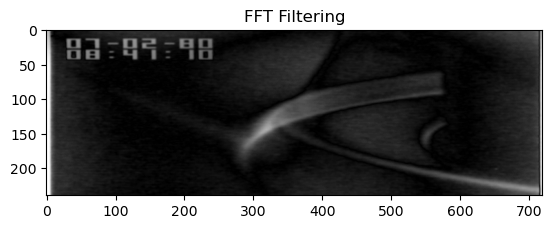

In [10]:
# do dft saving as complex output
dft = np.fft.fft2(blur_gray, axes=(0,1))

# apply shift of origin to center of image
dft_shift = np.fft.fftshift(dft)

# generate spectrum from magnitude image (for viewing only)
mag = np.abs(dft_shift)
spec = np.log(mag) / 20

# create white circle mask on black background and invert so black circle on white background
radius = 1
mask = np.zeros_like(img8)
cy = mask.shape[0] // 2
cx = mask.shape[1] // 2
cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
mask = 255 - mask

# blur the mask
mask2 = cv2.GaussianBlur(mask, (19,19), 0)

# apply mask to dft_shift
dft_shift_masked = np.multiply(dft_shift,mask) / 255
dft_shift_masked2 = np.multiply(dft_shift,mask2) / 255


# shift origin from center to upper left corner
back_ishift = np.fft.ifftshift(dft_shift)
back_ishift_masked = np.fft.ifftshift(dft_shift_masked)
back_ishift_masked2 = np.fft.ifftshift(dft_shift_masked2)


# do idft saving as complex output
img_back = np.fft.ifft2(back_ishift, axes=(0,1))
img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))
img_filtered2 = np.fft.ifft2(back_ishift_masked2, axes=(0,1))

# combine complex real and imaginary components to form (the magnitude for) the original image again
# multiply by 3 to increase brightness
img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
img_filtered = np.abs(3*img_filtered).clip(0,255).astype(np.uint8)
img_filtered2 = np.abs(3*img_filtered2).clip(0,255).astype(np.uint8)

plt.imshow(img_filtered, cmap='gray')
plt.title('FFT Filtering')
plt.show()

### Brightness Reconstruction
doi: 10.1109/TPS.2018.2828863.

In [20]:
def get_probability(img):
    
    im_norm = img / 255
    im_ave = np.average(im_norm)
    significance = np.log(im_norm+1) * (im_norm - im_ave)
    probability = significance / np.max(significance)
    fixed_probability = np.where(probability < 0, 0, probability)
            
    return fixed_probability * 255

def prob_to_edge(image, threshold):
    ratio = np.amax(image) / 255
    img8 = (image/ratio).astype('uint8')
    edge_ = cv2.Canny(img8, threshold[0], threshold[1])
    
    
    # ksize = 5
    # sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=ksize)
    # sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=ksize)
    # edge = np.sqrt(sobelx**2 + sobely**2)
    
    # gx, gy = np.gradient(image)
    # g = np.sqrt(gx**2 + gy**2)
    # dim = g.shape
    # edge = np.zeros_like(image)
    # for i in range(dim[0]):
    #     for j in range(dim[1]):
    #         edge[i,j] = 255 * (g[i,j] == 0)
            
    return edge_

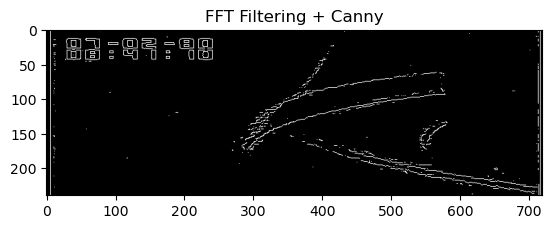

In [21]:
edge = prob_to_edge(img_filtered,[65,65])
plt.imshow(edge, cmap='gray')
plt.title('FFT Filtering + Canny')
plt.show()

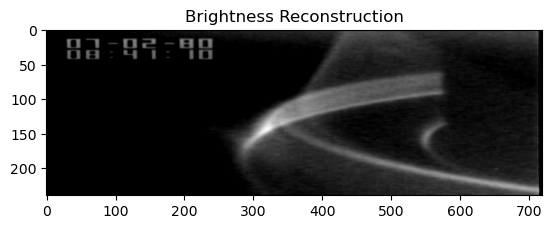

In [22]:
probability = get_probability(blur_gray)
plt.imshow(probability, cmap='gray')
plt.title('Brightness Reconstruction')
plt.show()

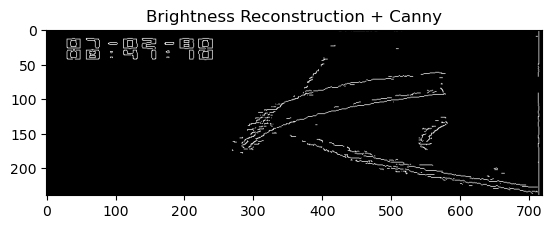

In [29]:
edge2 = prob_to_edge(probability,[70,85])
plt.imshow(edge2, cmap='gray')
plt.title('Brightness Reconstruction + Canny')
plt.show()

In [30]:
rho = 1  # This is the distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.zeros((img.shape[0],img.shape[1],3))  # creating a blank to draw lines on


lines = cv2.HoughLinesP(edge, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) # The output "lines" is an array containing endpoints of detected line segments

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

        
line_len=[]
for line in lines:
    for x1,y1,x2,y2 in line:
        line_len.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
        
# add the line_image as an extra layer on top of the original image
lines_edges = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 1, line_image, 0.5, 0,dtype =0)

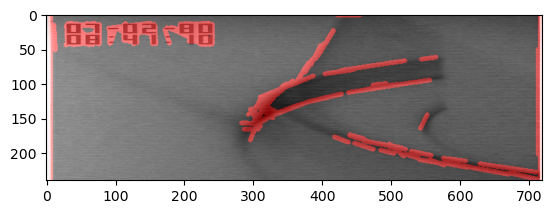

In [31]:
plt.imshow(lines_edges)

### Significance Tiling

In [49]:
# manually test image size for tiling
print(blur_gray.shape)
print(blur_gray.shape[0] % 24, blur_gray.shape[1] % 72)

(240, 720)
0 0


In [86]:
def img_split(img, kernel_size):
    img_height, img_width = img.shape
    tile_height, tile_width = kernel_size
    
    num_rows = img_height // tile_height
    num_cols = img_width // tile_width
    
    img = img.reshape(num_rows, tile_height, num_cols,tile_width)
    img = img.swapaxes(1,2).reshape(-1, tile_height, tile_width)

    return img

def recombine_tiles(img, img_shape, kernel_size):
    img_height, img_width = img_shape
    tile_height, tile_width = kernel_size
    
    num_rows = img_height // tile_height
    num_cols = img_width // tile_width
    
    img = img.reshape(num_rows, num_cols, tile_height, tile_width)
    img = img.swapaxes(1, 2).reshape(img_height, img_width)
    
    return img

In [138]:
bg_tiles = img_split(blur_gray, (24, 72))

In [139]:
def prob_tiles(img, kernel_size):
    
    tile_im = img_split(img, kernel_size)
    
    steps = tile_im.shape[0]
    
    for i in range(steps):
        tile_im[i] = get_probability(tile_im[i])
        
    combined_im = recombine_tiles(tile_im, img.shape, kernel_size)
    
    return combined_im

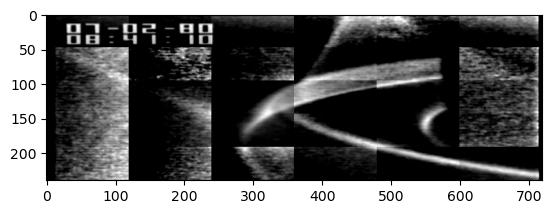

In [148]:
plt.imshow(prob_tiles(blur_gray, (48, 120)), cmap='gray')

## Training a model to predict X point coordinates based on synthetic XPR

In [20]:
cutoff_idx = 1000
end_idx = 1500

num_train_idx = cutoff_idx
num_val_idx = end_idx - cutoff_idx

In [23]:
# data = pickle.load(open('/projects/EKOLEMEN/plasmatv_data/synthetic_data/synthetic_outs.pl','rb'))
data = pickle.load(open('synthetic_outs.pl','rb'))
X=np.int_(np.dstack([v for k,v in data['image'].items()]))
y=np.dstack([v for k,v in data['RZ'].items()])

rand_ind=np.random.permutation(X.shape[2])

X_train = X[:,:,rand_ind[:cutoff_idx]]
y_train = y[:,:,rand_ind[:cutoff_idx]]

X_valid = X[:,:,rand_ind[cutoff_idx:end_idx]]
y_valid = y[:,:,rand_ind[cutoff_idx:end_idx]]

X_test = X[:,:,rand_ind[end_idx:]]
y_test = y[:,:,rand_ind[end_idx:]]

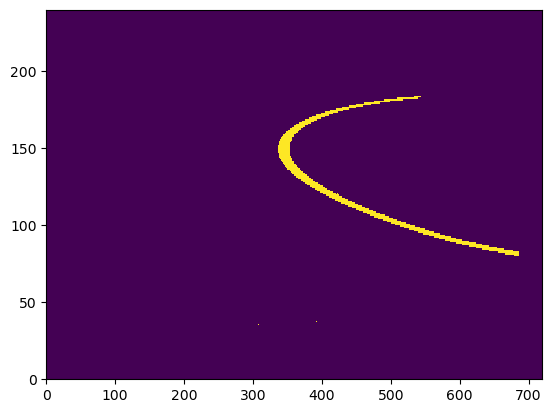

In [24]:
plt.pcolormesh(X_train[:,:,100])
plt.show()

Task 1: Train a model to predict a single X point using XPR synthetic data

Task 2: Load the syntheitc data (synthetic_outs_2d_ver2.pl) for both XPR and Emission Front and train a model to detect both inner and outer X points

Task 3: Detect the XPR and Emission Front in the raw image and redo Task 1&2 but with the detected lines rather than synthetic data

In [84]:
# hyperparameters
init_lr = 0.001
batch_size = 4
epochs = 2

# dummy dims
input_dim = 4
output_dim = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        
        super(Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.conv = nn.Conv2d(in_channels=input_dim, out_channels=20, kernel_size=(5,5))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.linear = nn.Linear(358, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.linear(x)
        return x

In [86]:
class TVDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[2]
    
    def __getitem__(self, index):
        return self.X[:,:,index], self.y[:,:,index]

In [87]:
model = Model(input_dim, output_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = nn.MSELoss()

# training history
H = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

In [88]:
# convert to torch tensors
X_train_d = torch.from_numpy(X_train).float()
y_train_d = torch.from_numpy(y_train).float()
X_valid_d = torch.from_numpy(X_valid).float()
y_valid_d = torch.from_numpy(y_valid).float()
X_test_d = torch.from_numpy(X_test).float()
y_test_d = torch.from_numpy(y_test).float()

# data load debugging
dataset = TVDataset(X_train_d, y_train_d)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [89]:
for e in range(epochs):
    model.train()
    
    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    val_correct = 0
    
    for i, (inputs, labels) in enumerate(dataloader):
        
        (inputs, labels) = (inputs.to(device), labels.to(device))
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_train_loss += loss.item()
        
        train_correct += (outputs.argmax(1) == labels).sum().item()
        
    H["train_loss"].append(total_train_loss / len(dataloader))
    H["train_acc"].append(train_correct / len(dataloader))

c:\Users\twoga\anaconda3\envs\torch2env\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 2])) that is different to the input size (torch.Size([20, 118, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (20) must match the size of tensor b (4) at non-singleton dimension 0